In [53]:
import pandas as pd
import json
import ast
import numpy as np



In [54]:
data = pd.read_csv("/Users/taeeunkwon/Downloads/vscode_projects/data/final_data_for_svr.csv")
data.head()

,Unnamed: 0,_id,duration,likes,speakers,subtitle_languages,summary,topics,title,transcript,views,recorded_date,published_date,speakers_list,sl_list,topics_list,processed_transcript,Inspired,Moved,Sad,Curious,Informed,Impressed,Hopeful,Amused,Fulfilled,Surprised,tb_score,vd_score,Unnamed: 0.1
0,0,21,992,17000,"[{'name': 'Mena Trott', 'occupation': 'Blogger...","[{'name': 'English', 'code': 'en'}, {'name': '...","The founding mother of the blog revolution, Mo...","[{'id': '4', 'name': 'culture'}, {'id': '13', ...",Meet the founder of the blog revolution,"Over the past couple of days, as I've been pre...",589115,2006-02-23,2006-08-25,['Mena Trott'],"['English', 'Vietnamese', 'Italian', 'Arabic',...","['culture', 'design', 'business', 'entertainme...",past couple day preparing speech become nervou...,0.90,0.8,0.7,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.133855,0.9996,0
1,1,1,957,110000,"[{'name': 'Al Gore', 'occupation': 'Climate ad...","[{'name': 'Greek', 'code': 'el'}, {'name': 'Gu...",With the same humor and humanity he exuded in ...,"[{'id': '3', 'name': 'climate change'}, {'id':...",Averting the climate crisis,"Thank you so much, Chris. And it's truly a gre...",3671801,2006-02-25,2006-06-27,['Al Gore'],"['Greek', 'Gujarati', 'English', 'Italian', 'S...","['climate change', 'culture', 'environment', '...",thank much chris truly great honor opportunity...,0.85,0.6,0.0,0.75,0.00,0.0,0.0,0.0,0.0,0.0,0.131762,0.9997,1
2,2,7,1266,60000,"[{'name': 'David Pogue', 'occupation': 'Techno...","[{'name': 'Greek', 'code': 'el'}, {'name': 'En...",New York Times columnist David Pogue takes aim...,"[{'id': '10', 'name': 'technology'}, {'id': '3...",Simplicity sells,"(Music: ""The Sound of Silence,"" Simon &amp; Ga...",2008487,2006-02-24,2006-06-27,['David Pogue'],"['Greek', 'English', 'Vietnamese', 'Italian', ...","['technology', 'computers', 'entertainment', '...",music sound silence simon amp garfunkel hello ...,0.00,0.0,0.0,0.90,0.80,0.6,0.0,0.0,0.0,0.0,0.155493,0.9999,2
3,3,47,1126,80000,"[{'name': 'David Deutsch', 'occupation': 'Phys...","[{'name': 'Greek', 'code': 'el'}, {'name': 'En...",Legendary scientist David Deutsch puts theoret...,"[{'id': '3', 'name': 'climate change'}, {'id':...",Chemical scum that dream of distant quasars,We've been told to go out on a limb and say so...,2694257,2005-07-14,2006-09-12,['David Deutsch'],"['Greek', 'English', 'Vietnamese', 'Italian', ...","['climate change', 'culture', 'environment', '...",told go limb say something surprising try want...,0.90,0.7,0.0,0.00,0.65,0.0,0.0,0.0,0.0,0.0,0.066814,0.9990,3
4,4,55,1524,14000,"[{'name': 'Jehane Noujaim', 'occupation': 'Fil...","[{'name': 'English', 'code': 'en'}, {'name': '...",Jehane Noujaim unveils her 2006 TED Prize wish...,"[{'id': '4', 'name': 'culture'}, {'id': '6', '...",My wish: A global day of film,I can't help but this wish: to think about whe...,489757,2006-02-26,2006-07-25,['Jehane Noujaim'],"['English', 'Vietnamese', 'Italian', 'Arabic',...","['culture', 'global issues', 'entertainment', ...",help wish think little kid friend ask genie co...,0.85,0.9,0.0,0.75,0.00,0.0,0.0,0.0,0.0,0.0,0.127882,0.9995,4


In [55]:
# Function to safely parse the structured string into a dictionary and extract the occupation
def extract_occupation(speaker_info):
    try:
        # Convert the string representation of list-dictionaries into actual list of dictionaries
        speaker_list = ast.literal_eval(speaker_info)
        # Extract the first speaker's occupation (assuming at least one speaker per talk)
        occupation = speaker_list[0]['occupation']
        return occupation
    except Exception as e:
        # In case of any error (e.g., malformed string, missing keys), return NaN
        return np.nan

# Apply the function to the 'speakers' column to create the new 'occupation' column
data['occupation'] = data['speakers'].apply(extract_occupation)

# Display the first few rows to verify the new column
data[['speakers', 'occupation']].head()

,speakers,occupation
0,"[{'name': 'Mena Trott', 'occupation': 'Blogger...","Blogger; cofounder, Six Apart"
1,"[{'name': 'Al Gore', 'occupation': 'Climate ad...",Climate advocate
2,"[{'name': 'David Pogue', 'occupation': 'Techno...",Technology columnist
3,"[{'name': 'David Deutsch', 'occupation': 'Phys...","Physicist, author"
4,"[{'name': 'Jehane Noujaim', 'occupation': 'Fil...",Filmmaker


Thought about multiple way to select or reduce variables but choose **Top N Occupations + 'Other' Category** method because we are trying to build an explanatory model

In [56]:
from collections import Counter
import re

# Normalize occupation strings to lowercase, split by common delimiters, and flatten the list
occupation_list = data['occupation'].str.lower().str.split(';|,|\sand\s|\s&\s').explode().str.strip()

# Count each unique occupation
occupation_counts = Counter(occupation_list)

# Get the top 50 occupations
top_50_occupations = [occupation for occupation, count in occupation_counts.most_common(50)]

# Remove empty string from top 50 occupations if present
top_50_occupations = [occ for occ in top_50_occupations if occ != '']

# Refine the encoding function to properly match and handle multiple occupations
def refine_encode_occupations(row_occupation):
    # Normalize and split the occupations in the row
    if pd.isna(row_occupation):
        row_occupations = []
    else:
        row_occupations = [occ.strip().lower() for occ in re.split(';|,|\sand\s|\s&\s', row_occupation)]
    
    # Encode each of the top 50 occupations
    return {f'occupation_{occ}': 1 if any(occ in occupation.split() for occupation in row_occupations) else 0 for occ in top_50_occupations}

# Apply the function and convert the result into a DataFrame
occupation_encoded_df = data['occupation'].apply(refine_encode_occupations)
occupation_encoded_df = pd.DataFrame(occupation_encoded_df.tolist())

# Concatenate the new occupation columns to the original DataFrame
data = pd.concat([data, occupation_encoded_df], axis=1)

# Display some of the new columns to verify the encoding
data[[f'occupation_{occ}' for occ in top_50_occupations[:5]]].head()  # Displaying only the first 5 for brevity


,occupation_educator,occupation_author,occupation_writer,occupation_entrepreneur,occupation_activist
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,1,0,0,0
4,0,0,0,0,0


In [57]:
# Correct the DataFrame creation by ensuring unique column names are maintained
occupation_encoded_df = occupation_encoded_df.loc[:, ~occupation_encoded_df.columns.duplicated()]

# Concatenate the corrected columns again to the original DataFrame (this time we will drop any previously added occupation columns to avoid confusion)
data = pd.concat([data.drop(columns=[col for col in data.columns if col.startswith('occupation_')]), occupation_encoded_df], axis=1)

# Display the corrected encoding for the first few rows and for the top 5 occupations
data[[f'occupation_{occ}' for occ in top_50_occupations[:5]]].head()

data.head(10)


,Unnamed: 0,_id,duration,likes,speakers,subtitle_languages,summary,topics,title,transcript,views,recorded_date,published_date,speakers_list,sl_list,topics_list,processed_transcript,Inspired,Moved,Sad,Curious,Informed,Impressed,Hopeful,Amused,Fulfilled,Surprised,tb_score,vd_score,Unnamed: 0.1,occupation,occupation_educator,occupation_author,occupation_writer,occupation_entrepreneur,occupation_activist,occupation_artist,occupation_journalist,occupation_designer,occupation_inventor,occupation_architect,occupation_musician,occupation_filmmaker,occupation_neuroscientist,occupation_psychologist,occupation_technologist,occupation_economist,occupation_social entrepreneur,occupation_poet,occupation_actor,occupation_photographer,occupation_professor,occupation_physicist,occupation_philosopher,occupation_engineer,occupation_physician,occupation_biologist,occupation_ceo,occupation_futurist,occupation_researcher,occupation_comedian,occupation_singer,occupation_historian,occupation_philanthropist,occupation_computer scientist,occupation_producer,occupation_roboticist,occupation_scientist,occupation_director,occupation_singer-songwriter,occupation_investor,occupation_founder,occupation_sleep scientist,occupation_storyteller,occupation_lawyer,occupation_anthropologist,occupation_environmentalist,occupation_social psychologist,occupation_politician,occupation_astrophysicist
0,0,21,992,17000,"[{'name': 'Mena Trott', 'occupation': 'Blogger...","[{'name': 'English', 'code': 'en'}, {'name': '...","The founding mother of the blog revolution, Mo...","[{'id': '4', 'name': 'culture'}, {'id': '13', ...",Meet the founder of the blog revolution,"Over the past couple of days, as I've been pre...",589115,2006-02-23,2006-08-25,['Mena Trott'],"['English', 'Vietnamese', 'Italian', 'Arabic',...","['culture', 'design', 'business', 'entertainme...",past couple day preparing speech become nervou...,0.90,0.80,0.7,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.133855,0.9996,0,"Blogger; cofounder, Six Apart",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,957,110000,"[{'name': 'Al Gore', 'occupation': 'Climate ad...","[{'name': 'Greek', 'code': 'el'}, {'name': 'Gu...",With the same humor and humanity he exuded in ...,"[{'id': '3', 'name': 'climate change'}, {'id':...",Averting the climate crisis,"Thank you so much, Chris. And it's truly a gre...",3671801,2006-02-25,2006-06-27,['Al Gore'],"['Greek', 'Gujarati', 'English', 'Italian', 'S...","['climate change', 'culture', 'environment', '...",thank much chris truly great honor opportunity...,0.85,0.60,0.0,0.75,0.00,0.0,0.00,0.0,0.0,0.0,0.131762,0.9997,1,Climate advocate,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,7,1266,60000,"[{'name': 'David Pogue', 'occupation': 'Techno...","[{'name': 'Greek', 'code': 'el'}, {'name': 'En...",New York Times columnist David Pogue takes aim...,"[{'id': '10', 'name': 'technology'}, {'id': '3...",Simplicity sells,"(Music: ""The Sound of Silence,"" Simon &amp; Ga...",2008487,2006-02-24,2006-06-27,['David Pogue'],"['Greek', 'English', 'Vietnamese', 'Italian', ...","['technology', 'computers', 'entertainment', '...",music sound silence simon amp garfunkel hello ...,0.00,0.00,0.0,0.90,0.80,0.6,0.00,0.0,0.0,0.0,0.155493,0.9999,2,Technology columnist,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,47,1126,80000,"[{'name': 'David Deutsch', 'occupation': 'Phys...","[{'name': 'Greek', 'code': 'el'}, {'name': 'En...",Legendary scientist David Deutsch puts theoret...,"[{'id': '3', 'name': 'climate change'}, {'id':...",Chemical scum that dream of distant quasars,We've been told to go out on a limb and say so...,2694257,2005-07-14,2006-09-12,['David Deutsch'],"['Greek', 'English', 'Vietnamese', 'Italian', ...","['climate change', 'culture', 'environment', '...",told go limb say something surprising try want...,0.90,0.70,0.0,0.00,0.65,0.0,0.00,0.0,0.

In [58]:
# See how many rows have 1 in the occupation columns
occupation_columns = [col for col in data.columns if col.startswith('occupation_')]
data['occupation_sum'] = data[occupation_columns].sum(axis=1)
data['occupation_sum'].value_counts()



occupation_sum
1    3102
0    1902
2     534
3      86
4       7
Name: count, dtype: int64

In [59]:
# Function to safely parse the structured string into a list of topics and extract topic names
def extract_topics(topic_info):
    try:
        # Convert the string representation of list-dictionaries into actual list of dictionaries
        topic_list = ast.literal_eval(topic_info)
        # Extract topic names and return them
        return [topic['name'].strip().lower() for topic in topic_list]
    except Exception as e:
        # In case of any error, return an empty list
        return []

# Apply the function to the 'topics' column
data['topic_list'] = data['topics'].apply(extract_topics)

# Flatten the list and count occurrences
topic_list = pd.Series([topic for sublist in data['topic_list'] for topic in sublist])
topic_counts = Counter(topic_list)

# Get the top 50 topics
top_50_topics = [topic for topic, count in topic_counts.most_common(50)]

# Display the top 50 topics
top_50_topics


['science',
 'technology',
 'ted-ed',
 'culture',
 'animation',
 'education',
 'society',
 'tedx',
 'social change',
 'global issues',
 'business',
 'design',
 'history',
 'health',
 'innovation',
 'humanity',
 'biology',
 'communication',
 'art',
 'future',
 'creativity',
 'community',
 'climate change',
 'entertainment',
 'environment',
 'activism',
 'sustainability',
 'personal growth',
 'medicine',
 'brain',
 'health care',
 'performance',
 'economics',
 'music',
 'nature',
 'collaboration',
 'psychology',
 'ted fellows',
 'animals',
 'work',
 'politics',
 'human body',
 'women',
 'invention',
 'identity',
 'kids',
 'storytelling',
 'government',
 'engineering',
 'equality']

In [60]:
# Function to encode the top 50 topics into binary columns
def encode_topics(row_topics):
    # Normalize and prepare the topics list from the row
    row_topics_set = set(row_topics)
    # Encode each of the top 50 topics
    return {f'topic_{topic}': 1 if topic in row_topics_set else 0 for topic in top_50_topics}

# Apply the function and convert the result into a DataFrame
topic_encoded_df = data['topic_list'].apply(encode_topics)
topic_encoded_df = pd.DataFrame(topic_encoded_df.tolist())

# Concatenate the new topic columns to the original DataFrame
data = pd.concat([data, topic_encoded_df], axis=1)

# Display some of the new columns to verify the encoding, showing only the first few rows for brevity
data[[f'topic_{topic}' for topic in top_50_topics[:5]]].head()

#show all the names of columns without truncation
pd.set_option('display.max_columns', None)
data.head(10)


,Unnamed: 0,_id,duration,likes,speakers,subtitle_languages,summary,topics,title,transcript,views,recorded_date,published_date,speakers_list,sl_list,topics_list,processed_transcript,Inspired,Moved,Sad,Curious,Informed,Impressed,Hopeful,Amused,Fulfilled,Surprised,tb_score,vd_score,Unnamed: 0.1,occupation,occupation_educator,occupation_author,occupation_writer,occupation_entrepreneur,occupation_activist,occupation_artist,occupation_journalist,occupation_designer,occupation_inventor,occupation_architect,occupation_musician,occupation_filmmaker,occupation_neuroscientist,occupation_psychologist,occupation_technologist,occupation_economist,occupation_social entrepreneur,occupation_poet,occupation_actor,occupation_photographer,occupation_professor,occupation_physicist,occupation_philosopher,occupation_engineer,occupation_physician,occupation_biologist,occupation_ceo,occupation_futurist,occupation_researcher,occupation_comedian,occupation_singer,occupation_historian,occupation_philanthropist,occupation_computer scientist,occupation_producer,occupation_roboticist,occupation_scientist,occupation_director,occupation_singer-songwriter,occupation_investor,occupation_founder,occupation_sleep scientist,occupation_storyteller,occupation_lawyer,occupation_anthropologist,occupation_environmentalist,occupation_social psychologist,occupation_politician,occupation_astrophysicist,occupation_sum,topic_list,topic_science,topic_technology,topic_ted-ed,topic_culture,topic_animation,topic_education,topic_society,topic_tedx,topic_social change,topic_global issues,topic_business,topic_design,topic_history,topic_health,topic_innovation,topic_humanity,topic_biology,topic_communication,topic_art,topic_future,topic_creativity,topic_community,topic_climate change,topic_entertainment,topic_environment,topic_activism,topic_sustainability,topic_personal growth,topic_medicine,topic_brain,topic_health care,topic_performance,topic_economics,topic_music,topic_nature,topic_collaboration,topic_psychology,topic_ted fellows,topic_animals,topic_work,topic_politics,topic_human body,topic_women,topic_invention,topic_identity,topic_kids,topic_storytelling,topic_government,topic_engineering,topic_equality
0,0,21,992,17000,"[{'name': 'Mena Trott', 'occupation': 'Blogger...","[{'name': 'English', 'code': 'en'}, {'name': '...","The founding mother of the blog revolution, Mo...","[{'id': '4', 'name': 'culture'}, {'id': '13', ...",Meet the founder of the blog revolution,"Over the past couple of days, as I've been pre...",589115,2006-02-23,2006-08-25,['Mena Trott'],"['English', 'Vietnamese', 'Italian', 'Arabic',...","['culture', 'design', 'business', 'entertainme...",past couple day preparing speech become nervou...,0.90,0.80,0.7,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.133855,0.9996,0,"Blogger; cofounder, Six Apart",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[culture, design, business, entertainment, sof...",0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1,1,957,110000,"[{'name': 'Al Gore', 'occupation': 'Climate ad...","[{'name': 'Greek', 'code': 'el'}, {'name': 'Gu...",With the same humor and humanity he exuded in ...,"[{'id': '3', 'name': 'climate change'}, {'id':...",Averting the climate crisis,"Thank you so much, Chris. And it's truly a gre...",3671801,2006-02-25,2006-06-27,['Al Gore'],"['Greek', 'Gujarati', 'English', 'Italian', 'S...","['climate change', 'culture', 'environment', '...",thank much chris truly great honor opportunity...,0.85,0.60,0.0,0.75,0.00,0.0,0.00,0.0,0.0,0.0,0.131762,0.9997,1,Climate advocate,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[climate change, culture, environment, global ...",1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,7,1266,60000,"[{'name': 'David Pogue', 'occupation': 'Techno...","[{'name': 'Greek', 'code': 'el'}, {'name': 

In [61]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Transform the 'likes' column to its logarithmic form to use as the target variable
data['log_likes'] = np.log(data['likes'] + 1)  # Add 1 to avoid log(0)

# Selecting input features
emotion_scores = ['Inspired', 'Moved', 'Sad', 'Curious', 'Informed', 'Impressed', 'Hopeful', 'Amused', 'Fulfilled', 'Surprised']
occupation_columns = [col for col in data.columns if col.startswith('occupation_')]
# get all the columns that start with 'topic_' except for topic_list
topic_columns = [col for col in data.columns if col.startswith('topic_') and col != 'topic_list']

features = ['duration', 'tb_score', 'vd_score'] + emotion_scores + occupation_columns + topic_columns

# Prepare the feature matrix and target vector
X = data[features]
y = data['log_likes']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the SVR model
svr_model = SVR(kernel='linear')
svr_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = svr_model.predict(X_test_scaled)

# Evaluate the model using RMSE and R² metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Print the performance metrics
print("RMSE:", rmse)
print("R² Score:", r2)

RMSE: 1.1121208650838275
R² Score: 0.45137122300642585


## Fine Tuning

In [62]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'C': [0.1, 1, 10],  # Regularization parameter
    'gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
    'degree': [2, 3, 4],  # Degree of the polynomial kernel function
    'epsilon': [0.1, 0.01, 0.001]  # Epsilon in the epsilon-SVR model
}

# Initialize the SVR model
svr = SVR()

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5, scoring='r2', verbose=2, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and best score
grid_search.best_params_, grid_search.best_score_

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV] END C=0.1, degree=2, epsilon=0.1, gamma=scale, kernel=poly; total time=   2.5s
[CV] END C=0.1, degree=2, epsilon=0.1, gamma=scale, kernel=poly; total time=   1.9s
[CV] END C=0.1, degree=2, epsilon=0.1, gamma=scale, kernel=poly; total time=   2.7s
[CV] END C=0.1, degree=2, epsilon=0.1, gamma=scale, kernel=rbf; total time=   3.2s
[CV] END C=0.1, degree=2, epsilon=0.1, gamma=scale, kernel=rbf; total time=   3.4s
[CV] END C=0.1, degree=2, epsilon=0.1, gamma=scale, kernel=rbf; total time=   3.5s
[CV] END C=0.1, degree=2, epsilon=0.1, gamma=scale, kernel=rbf; total time=   3.7s
[CV] END C=0.1, degree=2, epsilon=0.1, gamma=scale, kernel=rbf; total time=   3.8s
[CV] END C=0.1, degree=2, epsilon=0.1, gamma=scale, kernel=poly; total time=   2.2s
[CV] END C=0.1, degree=2, epsilon=0.1, gamma=scale, kernel=poly; total time=   2.5s
[CV] END C=0.1, degree=2, epsilon=0.1, gamma=scale, kernel=sigmoid; total time=   2.6s
[CV] END C=0.1,

({'C': 1, 'degree': 2, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'rbf'},
 0.49879860868924286)

In [64]:
# Set up the SVR model with the optimized parameters
optimized_svr = SVR(kernel='rbf', C=1, gamma='auto', epsilon=0.1)

# Fit the model
optimized_svr.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = optimized_svr.predict(X_test_scaled)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Print performance metrics
print("RMSE:", rmse)
print("R² Score:", r2)

RMSE: 1.0462416317471452
R² Score: 0.5144448098081633


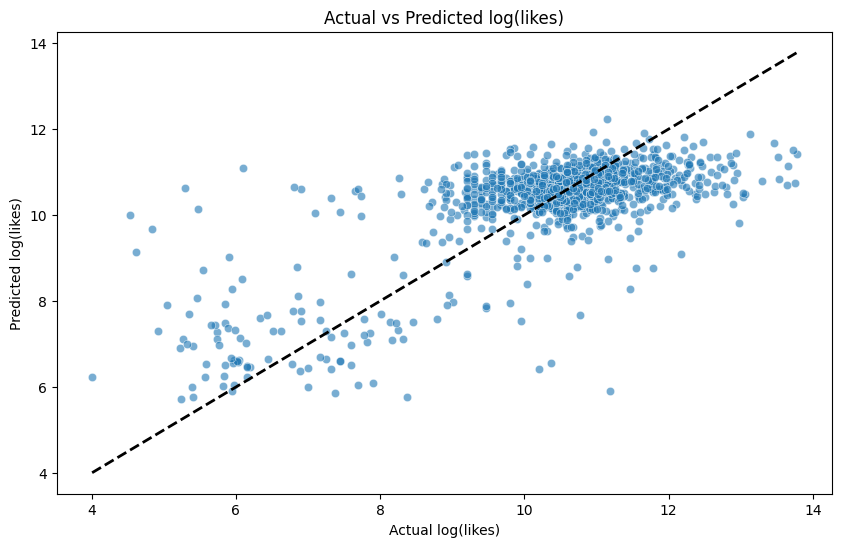

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming y_test are the actual values and y_pred are the predicted values from your model
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.xlabel('Actual log(likes)')
plt.ylabel('Predicted log(likes)')
plt.title('Actual vs Predicted log(likes)')

# Plotting the line of perfect predictions
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()


In [78]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load data and split (assuming 'data' is your DataFrame and 'features' contains all feature column names)
X = data[features]
y = data['log_likes']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit Lasso model
lasso = Lasso(alpha=0.05)  # Alpha is a hyperparameter to tune
lasso.fit(X_train_scaled, y_train)

# Check which features have non-zero coefficients
selected_features = [feature for feature, coef in zip(features, lasso.coef_) if coef != 0]

print("Selected Features:", selected_features)


Selected Features: ['duration', 'tb_score', 'vd_score', 'Inspired', 'Moved', 'Sad', 'Curious', 'Informed', 'Impressed', 'Hopeful', 'Amused', 'Fulfilled', 'Surprised', 'occupation_educator', 'occupation_author', 'occupation_singer', 'occupation_singer-songwriter', 'occupation_sum', 'topic_culture', 'topic_society', 'topic_social change', 'topic_business', 'topic_art', 'topic_entertainment', 'topic_personal growth', 'topic_brain', 'topic_music', 'topic_psychology', 'topic_human body', 'topic_equality']


In [79]:
# Using only the selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Standardize the selected features
scaler = StandardScaler()
X_train_selected_scaled = scaler.fit_transform(X_train_selected)
X_test_selected_scaled = scaler.transform(X_test_selected)

# Train the SVR model using the same parameters found earlier
optimized_svr = SVR(kernel='rbf', C=1, gamma='auto', epsilon=0.1)
optimized_svr.fit(X_train_selected_scaled, y_train)

# Predict on the test set
y_pred_selected = optimized_svr.predict(X_test_selected_scaled)

# Evaluate the model
rmse_selected = np.sqrt(mean_squared_error(y_test, y_pred_selected))
r2_selected = r2_score(y_test, y_pred_selected)

# Print performance metrics
print("RMSE with selected features:", rmse_selected)
print("R² Score with selected features:", r2_selected)


RMSE with selected features: 1.0653740694647753
R² Score with selected features: 0.496523910616406


## Analysis

In [81]:
# Get coefficients and feature names
coefficients = lasso.coef_
features = X_train.columns

# Combine coefficients and features, sort by absolute values of coefficients
feature_importance = sorted(zip(features, coefficients), key=lambda x: abs(x[1]), reverse=True)

# Display the features and their coefficients
for feature, coef in feature_importance:
    if coef != 0:  # only show non-zero coefficients, i.e., selected features
        # Print the feature and its coefficient
        print(f"{feature}: {coef:.4f}")


Inspired: 0.5185
Curious: 0.3636
Moved: 0.3303
Informed: 0.2914
Hopeful: 0.2791
Impressed: 0.2751
Amused: 0.1472
topic_psychology: 0.0961
occupation_educator: 0.0950
topic_brain: 0.0942
tb_score: 0.0878
topic_personal growth: 0.0741
topic_human body: 0.0668
Sad: 0.0588
Fulfilled: 0.0588
topic_culture: 0.0562
Surprised: 0.0472
occupation_sum: 0.0456
topic_entertainment: 0.0451
duration: 0.0356
topic_music: -0.0250
topic_business: 0.0184
topic_society: 0.0125
occupation_singer: -0.0108
vd_score: 0.0108
occupation_author: 0.0076
topic_social change: 0.0057
topic_art: -0.0037
topic_equality: 0.0020
occupation_singer-songwriter: -0.0005


## 1. Emotion Coefficients:
- **Inspired (0.5185):** The most influential emotion. Videos that leave viewers feeling inspired tend to receive more likes, possibly because such content is uplifting and resonates deeply, encouraging sharing and engagement.
- **Curious (0.3636):** Significantly impactful. Content that sparks curiosity effectively engages viewers, likely keeping them interested and motivated to explore more.
- **Moved (0.3303):** Strong positive influence. Emotional content that moves the audience can create a strong connection, enhancing likeability.

## 2. Topic Coefficients:

- **Psychology (0.0961), Brain (0.0942), Personal Growth (0.0741):** These topics have positive coefficients and are related to self-improvement and understanding human behavior, which are engaging and relatable subjects.
- **Culture (0.0562), Entertainment (0.0451):** These also positively influence likes, showing that content related to cultural themes and entertainment is popular.
- **Music (-0.0250):** Surprisingly, music has a slight negative influence, which might be due to oversaturation or specific viewer preferences in the dataset.

## 3. Occupation Coefficients:
- **Educator (0.0950):** Shows that videos featuring educators are liked more, likely because they are informative and reliable.
- **Singer (-0.0108), Singer-songwriter (-0.0005):** Interestingly, content from singers or singer-songwriters has a neutral to slightly negative impact, which might reflect viewer preferences or the specific context of their appearances in videos.

## Overall Insights:
- **Emotions Rule:** Videos that evoke strong, positive emotions are highly effective at driving likes. Content creators should aim to produce content that is inspiring, enlightening, and emotionally engaging.
- **Select Topics Carefully:** Focus on topics related to psychology, brain, and personal growth, which are more likely to engage viewers meaningfully. But try to avoid Music related topics
- **Consider the Presenter’s Background:** Videos featuring educators perform well, indicating a preference for educational and informative content. This could be leveraged in content planning and marketing strategies.